In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import*
from fastai.dataset import*

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects


In [ ]:
import torch, torchvision
print("torch:", torch.__version__)
print("CUDA toolkit:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print(torch.backends.cudnn.version())

torch.cuda.set_device(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(0))

In [3]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
PATH = Path('../data/pascal_2007')

In [5]:
trn_j = json.load((PATH/'train.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILENAME, ID, IMG_ID, CAT_ID,BBOX = 'file_name', 'id', 'image_id','category_id', 'bbox'


In [6]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILENAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]] 

IMG_PATH = Path('../data/pascal_2007/train')
trn_IMG_PATH = 'train'

In [7]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [8]:
# def show_img(im, figsize=None, ax=None):
#     if not ax: fig,ax = plt.subplots(figsize=figsize)
#     ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 224, 8))
#     ax.set_yticks(np.linspace(0, 224, 8))
#     ax.grid()
#     ax.set_ytickslabel([])
#     ax.set_xtickslabel([])
#     return ax

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [9]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

### Multi Class

In [10]:
MC_CSV = PATH/'tmp/mc.csv'

In [11]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [12]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [13]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns = ['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [14]:
f_model = resnet34
sz = 224
bs =64

In [15]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, MC_CSV, tfms=tfms)

In [16]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn =optim.Adam

In [18]:
lrf = learn.lr_find(1e-5, 100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   <lambda>                  
    0      1.49958    14.039322  0.4919    


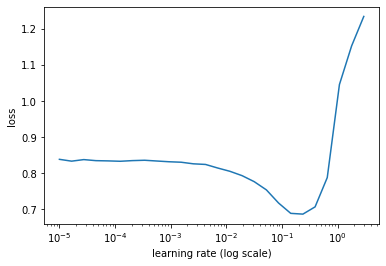

In [19]:
learn.sched.plot(0)

In [20]:
lr = 2e-2

In [21]:
learn.fit(lr,1, cycle_len=3, use_clr=(32,5))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   <lambda>                  
    0      0.32859    0.120702   0.9591    
    1      0.173499   0.077056   0.9747                    
    2      0.11578    0.074687   0.9748                    


[array([0.07469]), 0.9747999920845032]

In [22]:
lrs = np.array([lr/100, lr/10, lr])

In [23]:
learn.freeze_to(-2)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

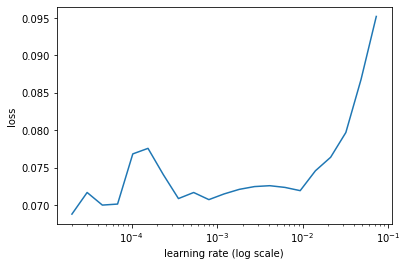

In [24]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [25]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr = (32,5))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   <lambda>                   
    0      0.080434   0.098073   0.9665    
    1      0.066841   0.092174   0.9707                     
    2      0.049362   0.085951   0.9712                     
    3      0.033465   0.08294    0.9746                     
    4      0.022357   0.081402   0.9753                     


[array([0.0814]), 0.9752999958992005]

In [26]:
learn.save('mclas')

In [27]:
learn.load('mclas')

In [28]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


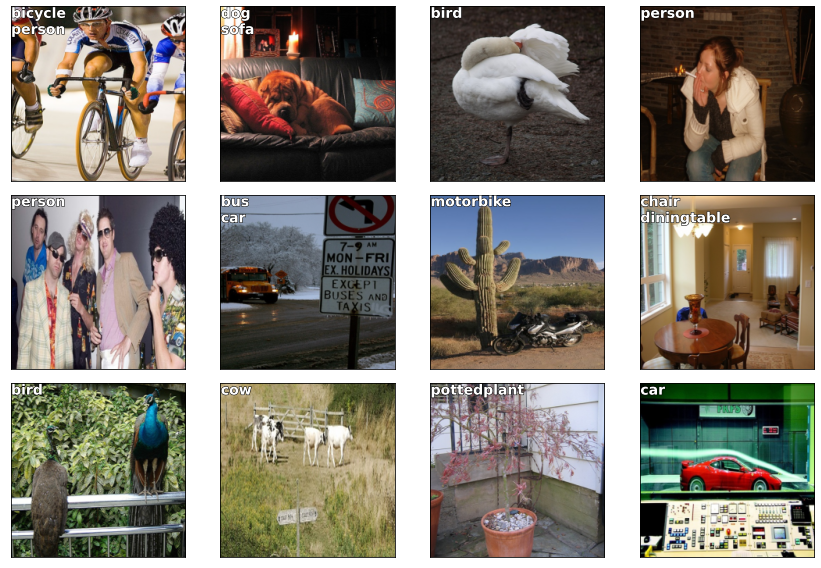

In [31]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0) , b)
plt.tight_layout()

### Bbox per cell

In [17]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model = resnet34
sz=224
bs=64

In [18]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]);mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [19]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [20]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn', 'bbox'])

df.to_csv(MBB_CSV, index=False)

In [21]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402
2,000023.jpg,229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374 87 132 122 196 179 194 228 212 ...


In [22]:
aug_tfms = [ RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
           RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
           RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, MBB_CSV, tfms=tfms, bs=bs, continuous=True)#, num_workers=4)

In [23]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm= mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]    

In [24]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None: prs = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [25]:
class ConcatLbDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)

    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [26]:
trn_ds2 =ConcatLbDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLbDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [27]:
x,y = to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [28]:
x,y = to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

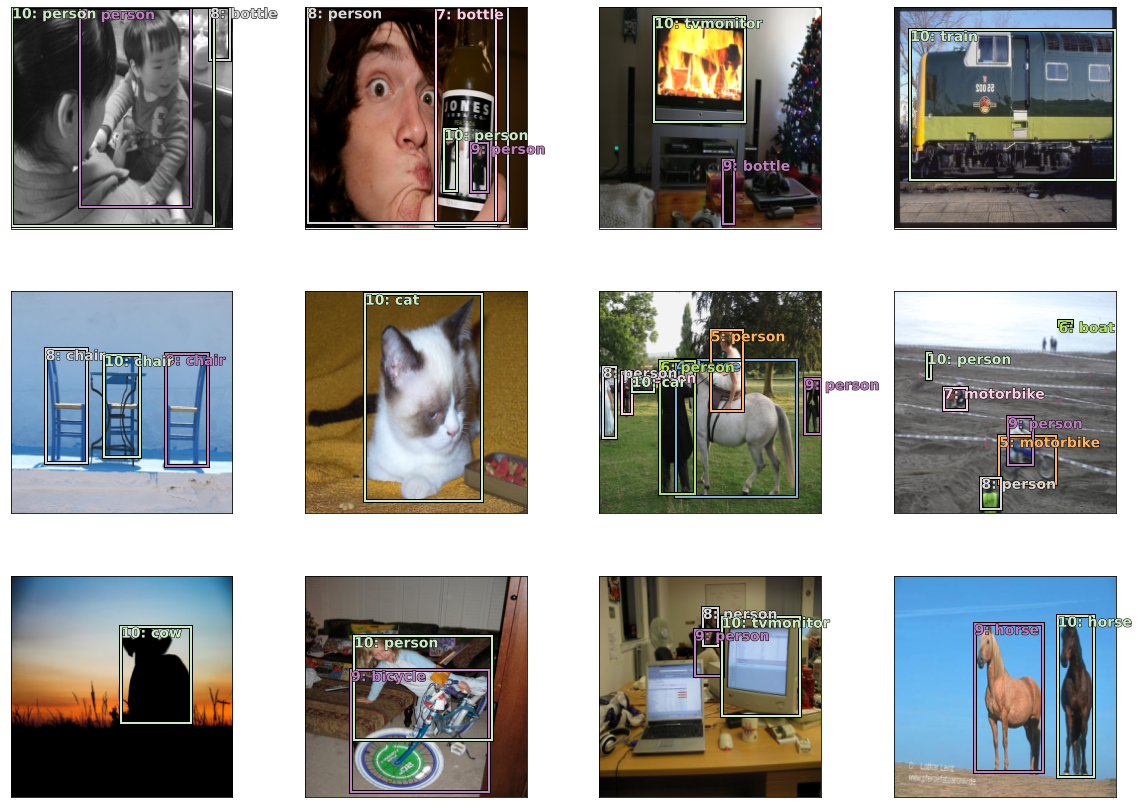

In [29]:
fig, axes =plt.subplots(3, 4, figsize=(16,12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i],y[0][i], y[1][i])
plt.tight_layout()

#### Set up model

In [41]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [42]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

(0.0, 1.0)

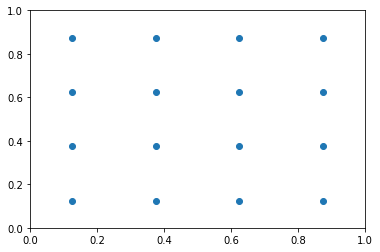

In [43]:
plt.scatter(anc_x, anc_y)
plt.xlim(0,1)
plt.ylim(0,1)

In [44]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.FloatTensor of size 16x4]

In [45]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [46]:
anchor_cnr =  hw2corners(anchors[:, :2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.FloatTensor of size 16x4]

In [47]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [48]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x,k):
    bs, nf, gx, gy = x.size()
    x= x.permute(o, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf//k)
        

In [49]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)

    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [50]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1)
#        self.sconv1 = StdConv(256, 256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#        x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

###  Train

In [51]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:,-1]
        w = self.get_weight(x, t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes

    def get_weight(self, x, t): return None

loss_f = BCE_Loss(len(id2cat))